In [ ]:
# default_exp core

# Core

Find the meme you are looking for!

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

The first iteration of `memery` is a simple CLI tool that you can use on a folder with subfolders of images to return the closest `n` images based on a text or image search. 

This is the core module, which loads the CLIP model and the encodings of all the images in the folder, then tokenizes the search text or image, and finally returns a sorted list of filenames.

# Modular flow system

I'm using the Neural Search design pattern as described by Han Xiao in e.g. [General Neural Elastic Search and Go Way Beyond](https://hanxiao.io/2019/07/29/Generic-Neural-Elastic-Search-From-bert-as-service-and-Go-Way-Beyond)&c.

Essentially a pipeline model, here we think of Flows and Executors.

**Flows** are specific patterns of data manipulation and storage. **Executors** are the operators that transform the data within the flow. 

There are two core flows to any search system: indexing, and querying. The plan here is to make executors that can be composed into flows and then compose the flows into a UI that supports querying and, to some extent, indexing as well.

The core executors for this use case are:
 - Loader
 - Crafter
 - Encoder
 - Indexer
 - Ranker
 - Gateway
 

## Gateway

Takes a query and processes it through either Indexing Flow or Querying Flow, passing along arguments. The main entrypoint for each iteration of the index/query process.

Querying Flow can technically process either text or image search, becuase the CLIP encoder will put them into the same embedding space. So we might as well build in a method for either, and make it available to the user, since it's impressive and useful and relatively easy to build.

Eventually the Gateway process probably needs to be quite complicated, for serving all the different users and for delivering REST APIs to different clients. For now we will run this locally, in a notebook. Then build out a GUI from there using `mediapy` or `widgets`. That should reveal the basic necessities of the UI, and then we can separate out the GUI client from the server.

In [ ]:
#export
import torch
from pathlib import Path
from memery.loader import get_image_files, archive_loader, db_loader, treemap_loader 
from memery.crafter import crafter
from memery.encoder import image_encoder, text_encoder
from memery.indexer import join_all, build_treemap, save_archives
from memery.ranker import ranker

## Flows

In [ ]:
#export
def indexFlow(path):
    root = Path(path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    filepaths = get_image_files(root)
    archive_db = {}
    
    archive_db, new_files = archive_loader(filepaths, root, device)
    print(f"Loaded {len(archive_db)} encodings")
    print(f"Encoding {len(new_files)} new images")
    crafted_files = crafter(new_files, device)
    new_embeddings = image_encoder(crafted_files, device)
    
    db = join_all(archive_db, new_files, new_embeddings)
    print("Building treemap")
    t = build_treemap(db)
    
    print(f"Saving {len(db)}images")
    save_paths = save_archives(root, t, db)
    print("Done")
    return(save_paths)

In [ ]:
save_paths = indexFlow('./images')

0it [00:00, ?it/s]

Loaded 58 encodings
Encoding 0 new images


0it [00:00, ?it/s]

Building treemap
Saving 58images
Done


In [ ]:
save_paths

('images/memery.pt', 'images/memery.ann')

In [ ]:
#export
def queryFlow(path, query): 
    root = Path(path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    dbpath = root/'memery.pt'
    db = db_loader(dbpath)
    treepath = root/'memery.ann'
    treemap = treemap_loader(treepath)
    
    if treemap == None or db == {}:
        dbpath, treepath = indexFlow(root)
        treemap = treemap_loader(Path(treepath))
        db = file
    
    print(f"Searching {len(db)} images")
    query_vec = text_encoder(query, device)
    indexes = ranker(query_vec, treemap)
    ranked_files = [[v['fpath'] for k,v in db.items() if v['index'] == ind] for ind in indexes]
    return(ranked_files)

        

In [ ]:
ranked = queryFlow('./images', 'a funny dog meme')

Searching 58 images


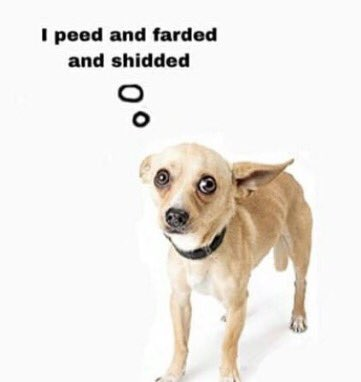

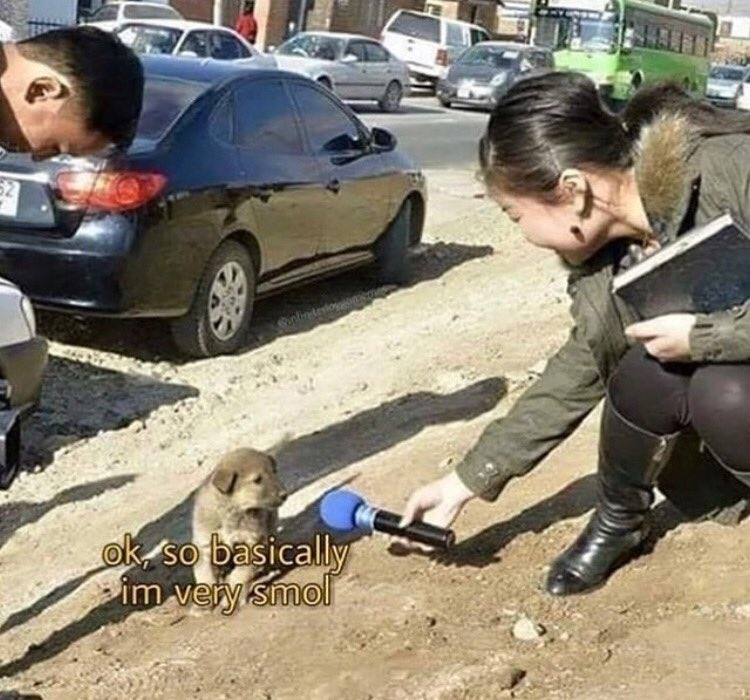

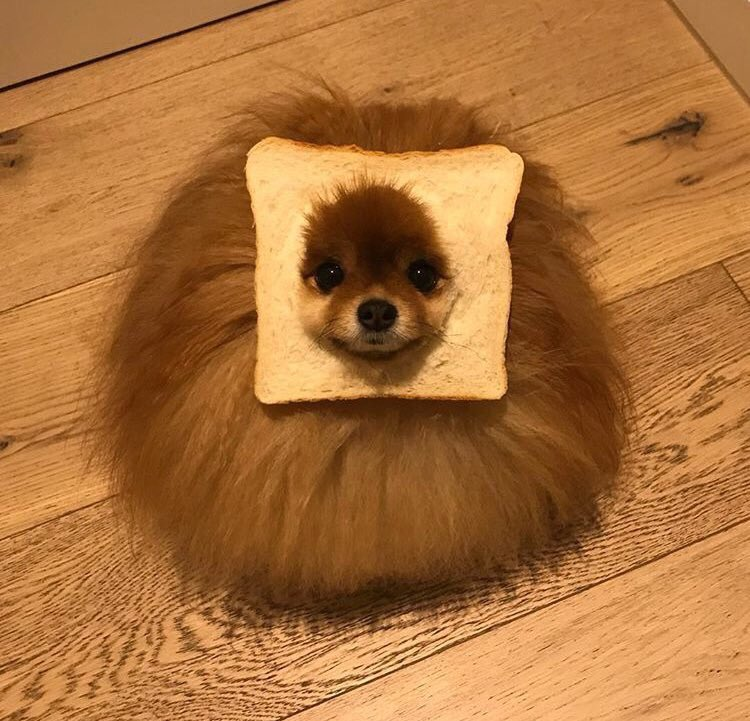

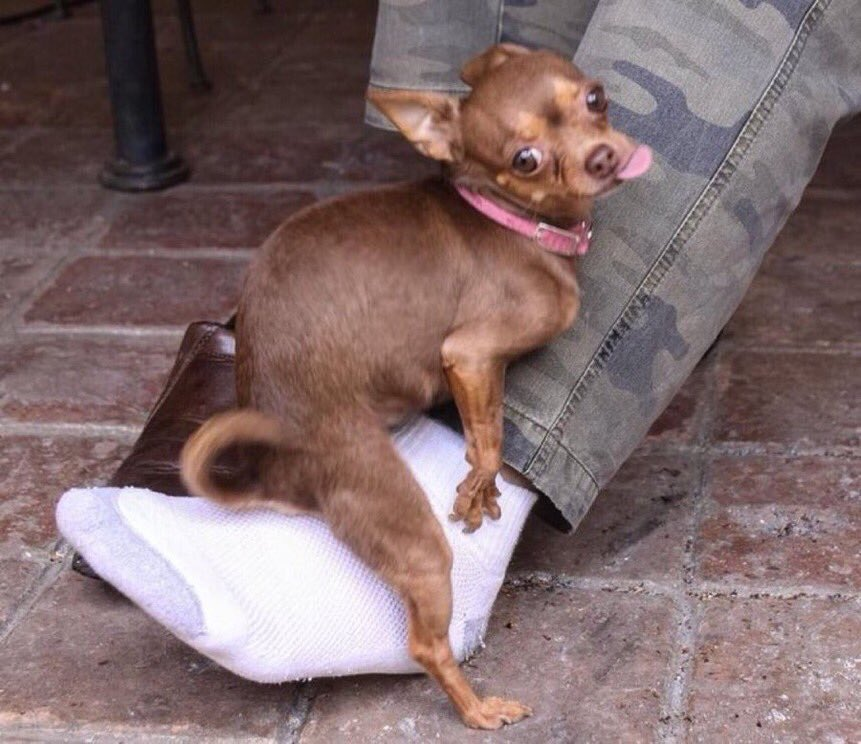

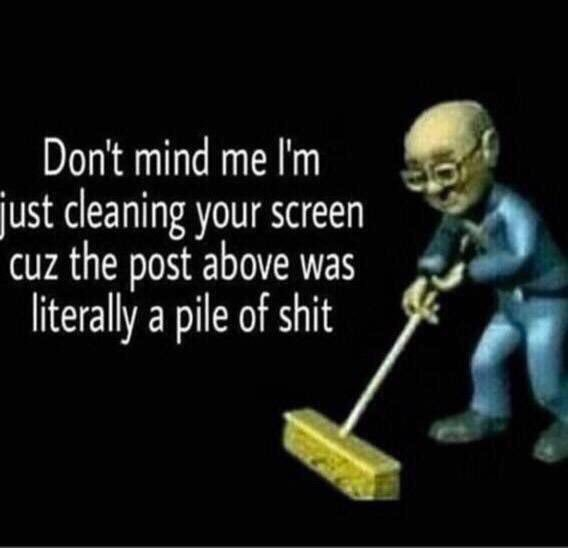

In [ ]:
printi(ranked)